# Visualizing category centroids
With this visualization, I wanted to look at the category centroids and the objects that are most similar to the target category (butterflies in this case) but are not actually from that category. 

In [1]:
# Import necassary packages
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
import math

# Set seabron theme
sns.set_theme(style='ticks', rc={"axes.spines.right": False, "axes.spines.top": False, "figure.dpi":300, 'savefig.dpi':300}, font='Arial')

In [2]:
# Define centroid and Euclidian distance functions
def centroid(df: pd.DataFrame):
    """Avergaes values across x and y axes to get the centroid of a group of coords"""
    _len = len(df)
    center_x = sum(df['x']) / _len
    center_y = sum(df['y']) / _len
    return [center_x, center_y]

def get_euclidian_distance(row, centroids):
    """Calculates a simple equclidian distance between the centroid and any other point in the DS"""
    return math.sqrt(math.pow(row['x'] - centroids[0], 2) + math.pow(row['y'] - centroids[1], 2))

Read in the the file that contains object categories and another dataset with the MDS embeddings. Then, I will separate the object information from the main dataset to preserve it and merge back together after the PCA analysis.

In [3]:
coords = pd.read_excel('CMDSCALECoordinates.xlsx')
categories =  pd.read_excel('file_names.xlsx')
df = categories.merge(coords, on='resource', how='inner')
cat_res = df[['category', 'resource']]
df = df.drop('category', axis=1)
df = df.drop('resource', axis=1)

In [4]:
# Run PCA
pca = PCA(n_components=2).fit_transform(df)
df = pd.DataFrame()
df[['category', 'resource']] = cat_res

# Add the first two components back to the main DS
df['x'] = pca[:,0]
df['y'] = pca[:,1]

Now, I will get the isolated coordinates specifically for the target category (butterflies) and calculate the centroid for that category along with Euclidian distances of all objects in the category to the centroid.

In [ ]:
butterflies = df[df['category'] == 'butterfly']
centroid = centroid(butterflies)

butterflies['cent_dist'] = butterflies.apply(get_euclidian_distance, args=(centroid,), axis=1)
butterflies = butterflies.reset_index().drop('index', axis=1) # Need to recalculate indices here for enumerating rows correctly for image retrieval

To make better distance judgements I will take the target cateegory and calculate distances that are in the 25th, 75th, and 100th percentiles to filter out distractors (other categories) that are too far away. This will also help to create circles around the centroid.

In [6]:
first_quantile = butterflies['cent_dist'].quantile(q=0.25)
third_quantile = butterflies['cent_dist'].quantile(q=0.75)
fourth_quantile = butterflies['cent_dist'].quantile(q=1.)

In [ ]:
# Choose distractors and filter out everything that is beyond 100th percentile
distractors = df[df['category'] != 'butterfly']
distractors['cent_dist'] = distractors.apply(get_euclidian_distance, args=(centroid,), axis=1)
distractors = distractors[distractors['cent_dist'] <= fourth_quantile]
distractors = distractors.reset_index().drop('index', axis=1) # Need to recalculate indices here for enumerating rows correctly for image retrieval

Finally, let's plot the results. As with the whole dataset visualization, I will use offset images and annotation boxes to plot images. There is no way to plot shapes in seaborn/matplotlib, so I will just use a simple point and blow it up to the radius of the percentile. I also played around with layering so that the colors line up with each other and indicate the **0th-25th and 75th-100th ranges**.

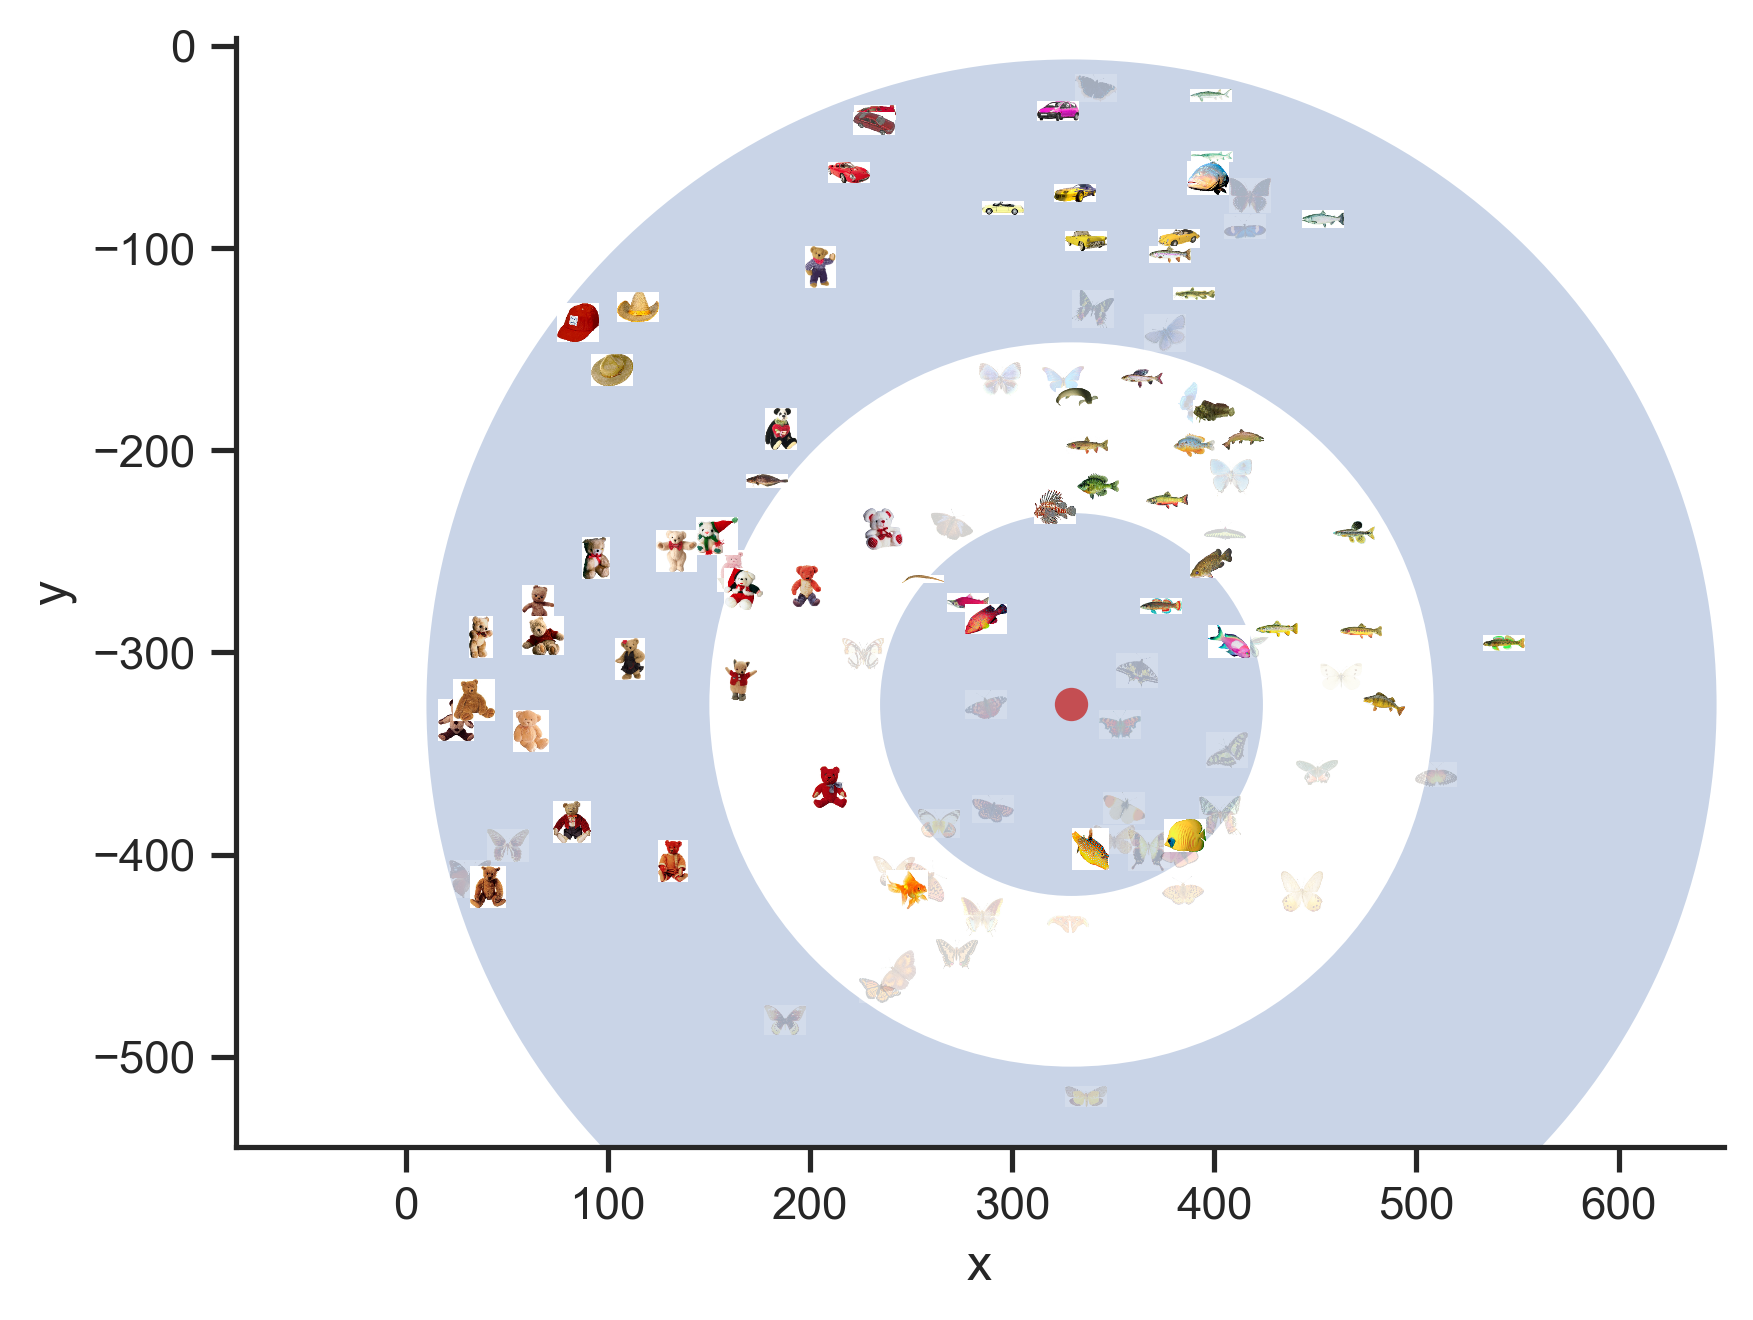

In [8]:
fig, ax = plt.subplots()

ax.axis('equal') # Set to equal to get even circles

# Plot invisible points
sns.scatterplot(x=butterflies['x'], y=butterflies['y'], ax=ax, s=0)
sns.scatterplot(x=distractors['x'], y=distractors['y'], ax=ax, color='yellow', s=0)

# Plot percentile circles
ax.plot([centroid[0]],[centroid[1]], 'o', ms=fourth_quantile, mec='none', alpha=0.3, mfc='b')
ax.plot([centroid[0]],[centroid[1]], 'o', ms=third_quantile, alpha=1, mec='none', mfc='w')
ax.plot([centroid[0]],[centroid[1]], 'o', ms=first_quantile, mec='none', alpha=0.3, mfc='b')

# Read target images
images_b = []
for name in butterflies['resource']:
    img = plt.imread('Resources/' + str(name) + '.png')
    images_b.append(img)

# Read distractor images
images_d = []
for name in distractors['resource']:
    img = plt.imread('Resources/' + str(name) + '.png')
    images_d.append(img)

# Plot the target images and make them opaque to highlight distractors
for i, image_path in enumerate(images_b):
    image = OffsetImage(image_path, zoom=0.1, alpha=0.2)
    image.image.axes = ax
    ab = AnnotationBbox(image, (butterflies['x'][i], butterflies['y'][i]), frameon=False)
    ax.add_artist(ab)

# Plot distractor images
for i, image_path in enumerate(images_d):
    image = OffsetImage(image_path, zoom=0.1)
    image.image.axes = ax
    ab = AnnotationBbox(image, (distractors['x'][i], distractors['y'][i]), frameon=False)
    ax.add_artist(ab)

ax.plot([centroid[0]],[centroid[1]], 'o', ms=8, mec='none', mfc='r')

Okay, it seems like butterflies are visually similar to plushie bears which kind of makes sense since their two arms and two legs kind of correspond in shape to butterfly wings. There are also some fish in there which are mostly yellow, so color might me another dimension for defining similarity.